In [1]:
import os
os.chdir("utils")

In [2]:
# Initialization
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

raw_tr = pd.read_csv("../data/train.csv.zip")
raw_tr = raw_tr.replace(to_replace=-999, value=np.nan)

raw_te = pd.read_csv("../data/test.csv.zip")
raw_te = raw_te.replace(to_replace=-999, value=np.nan)

In [3]:
# Explore NaNs
nans = raw_tr.isnull() 
nan_cols = nans.sum(axis=0) / raw_tr.shape[0]
nan_rows = nans.sum(axis=1)

with pd.option_context('display.float_format','{:.4%}'.format):
     print("NaN column summary:\n{}\n".format(nan_cols[nan_cols > 0]))
     print("NaN row summary:\n{}".format(nan_rows[nan_rows > 0]))
     
print("\nShapes")
print("\traw: {}".format(raw_tr.shape))
print("\tdrop rows: {}".format(raw_tr.dropna(axis=0).shape))
print("\tdrop cols: {}".format(raw_tr.dropna(axis=1).shape))

NaN column summary:
DER_mass_MMC             15.2456%
DER_deltaeta_jet_jet     70.9828%
DER_mass_jet_jet         70.9828%
DER_prodeta_jet_jet      70.9828%
DER_lep_eta_centrality   70.9828%
PRI_jet_leading_pt       39.9652%
PRI_jet_leading_eta      39.9652%
PRI_jet_leading_phi      39.9652%
PRI_jet_subleading_pt    70.9828%
PRI_jet_subleading_eta   70.9828%
PRI_jet_subleading_phi   70.9828%
dtype: float64

NaN row summary:
1          7
2          8
3         10
4         10
7          7
          ..
249995    11
249996    11
249997     7
249998    10
249999    11
Length: 181886, dtype: int64

Shapes
	raw: (250000, 32)
	drop rows: (68114, 32)
	drop cols: (250000, 21)


In [4]:
################################################################################
# Prepare data and labels
################################################################################

# Drop rows with NaNs
#data = raw.dropna(axis=0)

# Drop columns with NaNs
#data = raw.dropna(axis=1)

# Replace NaNs with mean of the column
#means = raw_tr.means()
#train = raw_tr.fillna(means)
#test = raw_te.fillna(means)

# Signal = 1, Background = 0
train = raw_tr.replace({'s':1,'b':0})
test = raw_te.replace({'s':1,'b':0})

# Split data and labels
X = train.drop(columns=['Id','Prediction'])
y = train['Prediction']

# Standarize data
X = (X-X.mean())/X.std()

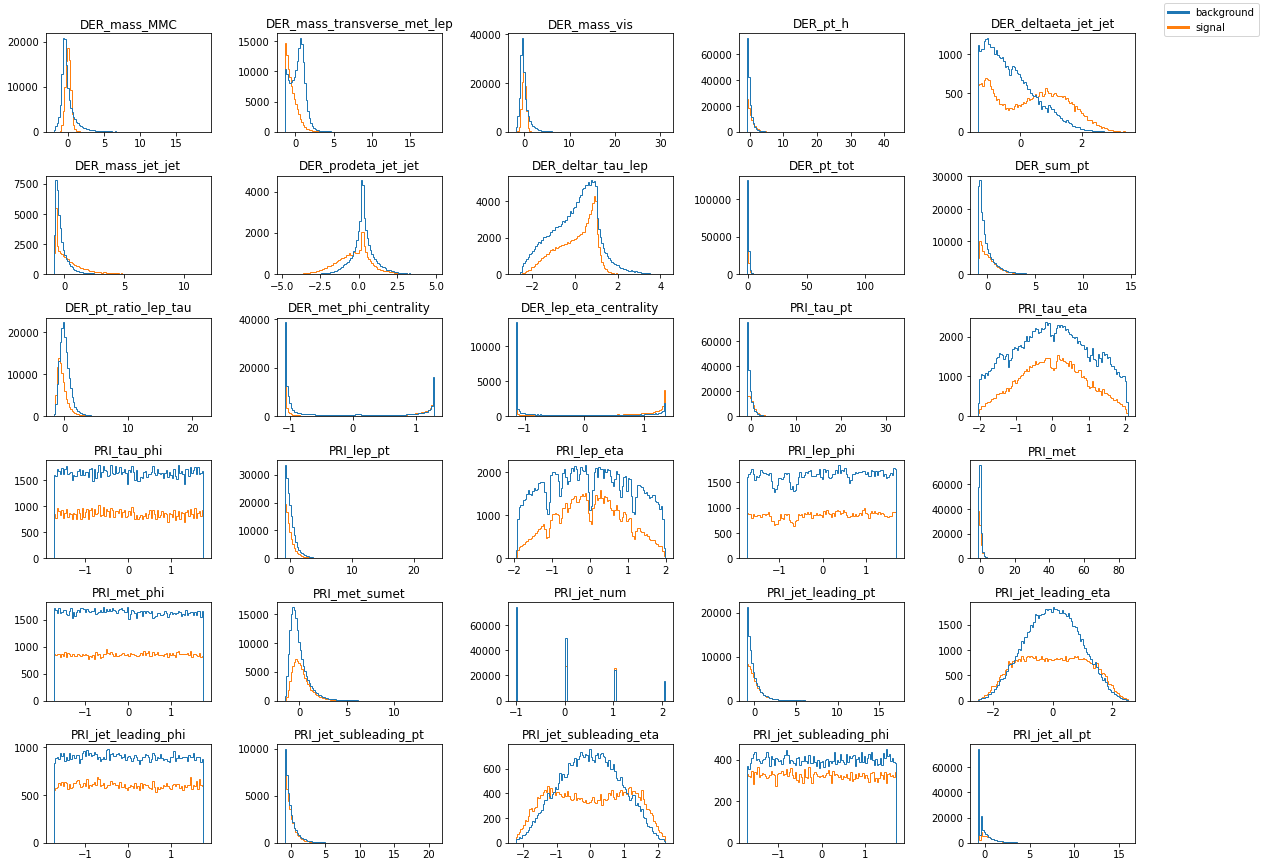

In [5]:
from matplotlib.lines import Line2D
def plot_histogram(y, X):
    mask = (y == 0)
    labels = ("background","signal")
    n = X.shape[1]

    nrows = (n+4)//5
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(16,12))

    for k, name in enumerate(X):
        row = k // ncols
        col = k % ncols
        axs[row, col].hist([X[name][mask], X[name][~mask]], 
                 label=labels, 
                 bins=100, 
                 histtype='step');
        axs[row, col].set_title(name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    fig.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()

plot_histogram(y, X)

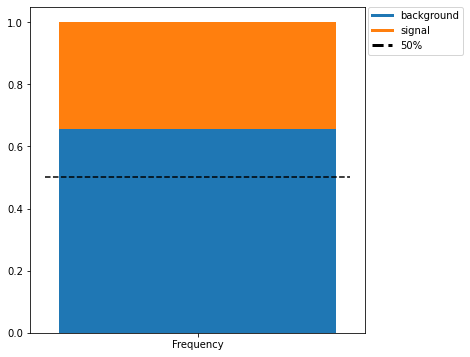

In [6]:
def plot_bar_counts(y, X):
    width = 0.5
    idx = (1,)
    labels = ("background","signal","50%")

    vals, counts = np.unique(y, return_counts=True)
    assert (len(vals) == 2)

    b = counts[vals == 0] / y.shape[0]
    s = counts[vals == 1] / y.shape[0]

    plt.figure(figsize=(6,6))
    plt.bar(idx, b, width)
    plt.bar(idx, s, width, bottom=b)
    plt.xticks(idx, ('Frequency',))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]

    left, right = plt.xlim()
    plt.hlines(0.5, left, right, linestyle='--')
    colors.append('black')
    lines.append(Line2D([0], [0], color='black', linewidth=3, linestyle='--'))

    plt.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plot_bar_counts(y, X)

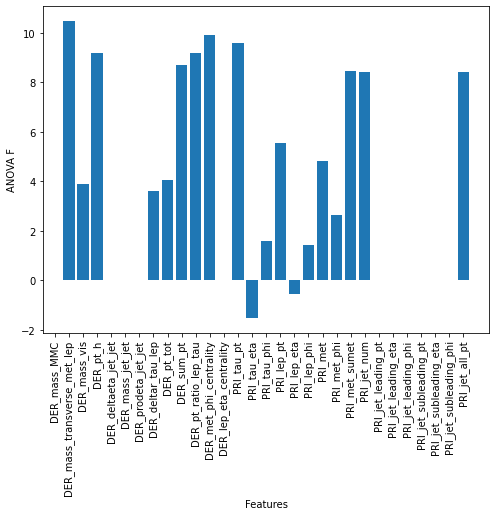

In [7]:
from scipy import stats

# ANOVA:
#  - https://dzone.com/articles/correlation-between-categorical-and-continuous-var-1

corr = np.empty(train.shape[1]-2)
cols = [col for col in train.drop(columns=['Id','Prediction'])]
    
for j, col in enumerate(cols):
    F, p = stats.f_oneway(train[train['Prediction']==0][col],
                              train[train['Prediction']==1][col])
    corr[j] = F

idx = np.arange(corr.shape[0])
plt.figure(figsize=(8,6))
plt.bar(idx, np.log(corr))
plt.xticks(idx, cols, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F')
plt.show()

## Prepare Features



In [8]:
from data import build_poly, prepare_feautres

## Hyper-Parameter Selection



In [9]:
from abc import ABC, abstractmethod
from implementations import reg_logistic_regression
from costs import reg_logistic_error
from helpers import sigmoid

class Classifier(ABC):
    """Metaclass for classifier classes."""

    def __init__(self):
        pass

    @abstractmethod
    def fit(self, y, tx):
        raise NotImplementedError

    @abstractmethod
    def predict(self, w, tx):
        raise NotImplementedError

    @abstractmethod
    def compute_loss(self, y, tx, w):
        raise NotImplementedError
    

class RegularizedLogisticRegression(Classifier):
    """Implementation of regularized logistic regression."""

    def __init__(self, gamma, lambda_, reg, max_iters=1000, early_stopping=True, tol=0.0001, patience=10):
        self.gamma = gamma
        self.lambda_ = lambda_
        self.reg = reg
        self.early_stopping = early_stopping,
        self.tol = tol,
        self.patience = patience
        self.max_iters = max_iters

    def fit(self, y, tx):
        return self.__reg_logistic_regression(y, tx)

    def predict(self, w, oos):
        return np.rint(sigmoid(oos @ w))

    def __reg_logistic_regression(self, y, tx):

        return reg_logistic_regression(
            y=y,
            tx=tx,
            lambda_=self.lambda_,
            reg=self.reg,
            initial_w=np.zeros((tx.shape[1])),
            max_iters=self.max_iters,
            gamma=self.gamma,
            early_stopping=self.early_stopping,
            tol=self.tol,
            patience=self.patience
        )

    def compute_loss(self, y, tx, w):
        
        return reg_logistic_error(
            y=y,
            tx=tx,
            w=w,
            lambda_=self.lambda_,
            reg=self.reg
        )

In [24]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def prepare_split_data(y, tx, degree, k_fold, seed):
    """
    Split the dataset based on k-fold cross validation and prepare features. 
    Returns the k splits.
    """
    k_indices = build_k_indices(y, k_fold, seed)
    
    tx_trs = []
    y_trs = []
    tx_tes = []
    y_tes = []
    
    for k in range(k_fold):
        # get k-th subgroup in test, others in train
        mask = np.full((y.shape[0]), False, dtype=bool)
        mask[k_indices[k]] = True
    
        y_te = y[mask]
        tx_te = tx[mask]
    
        mask = ~mask
        y_tr = y[mask]
        tx_tr = tx[mask]
        
        # Replace NaNs and standarize
        tx_tr, mean, std, mean_nan, _ = prepare_feautres(tx_tr, degree)
        tx_te, _, _, _, _ = prepare_feautres(tx_te, degree, mean_nan, mean, std)
        
        tx_trs.append(tx_tr)
        y_trs.append(y_tr)
        tx_tes.append(tx_te)
        y_tes.append(y_te)
    
    return y_trs, tx_trs, y_tes, tx_tes

In [11]:
from cross_validation import *

def cross_validation(y_tr, tx_tr, y_te, tx_te, comb, verbose=2):
    # instantiate the the classifier
    clf = RegularizedLogisticRegression(**comb, max_iters=200, tol=0.001, patience=5)
    # fit the model
    w, loss = clf.fit(y_tr, tx_tr)
    # calculate the loss for train and test data
    loss_tr = clf.compute_loss(y_tr, tx_tr, w)
    loss_te = clf.compute_loss(y_te, tx_te, w)
    # compute performance metrics
    p = clf.predict(w, tx_te)
    f1 = f1_score(y_te, p)
    acc = accuracy(y_te, p)
        
    return loss_tr, loss_te, f1, acc

In [35]:
import itertools as it

def model_selection(y, tx, k_fold, degree, grid, seed, verbose=2):
    
    max_loss = np.finfo(float).min
    max_acc = np.finfo(float).min

    # Generate total permuations of hps for gridsearch
    k, v = zip(*grid.items())
    permutations = [dict(zip(k, values)) for values in it.product(*v)]
    losses = {
        "loss_tr": [],
        "loss_te": [],
        "f1_te": [],
        "acc_te": []
    }
    
    print(f'Training on {int((1-1/k_fold)*y.shape[0])} samples')
    for permutation in permutations:
        print(f'Seed: {seed}, Permutation: {str(permutation)}')
        y_trs, tx_trs, y_tes, tx_tes = prepare_split_data(y, tx, degree, k_fold, seed)
        # Cross validation
        trl = 0.0
        tel = 0.0
        f1 = 0.0
        acc = 0.0
        for k in range(k_fold):
            tr, te, f1l, accl = cross_validation(
                y_trs[k],
                tx_trs[k],
                y_tes[k],
                tx_tes[k],
                comb=permutation
            )
            trl += tr
            tel += te
            f1 += f1l
            acc += accl

            if verbose > 1: print(f'\t\t\tTR={tr:.4e} | TE={te:.4e} | F1:{f1l:.4f} | ACC:{accl:.4f}')
                    
            if ~np.all(np.isfinite((tr, te, f1, acc))): break
        
        # k+1 needed to account for early exit due to NaNs or infs.
        losses["loss_tr"].append(trl / (k+1))
        losses["loss_te"].append(tel / (k+1))
        losses["f1_te"].append(f1 / (k+1))
        losses["acc_te"].append(acc / (k+1))
        
        if verbose > 0: print('\t'+' | '.join([ f'{key} = {val[-1]:.4f}' for key, val in losses.items() ]))

    idx = np.argmax(losses["acc_te"])
    print(f'\nMINIMUMS:')
    print(f'\tBest parameters: {str(permutations[idx])}')
    print(f'\tAccuracy: {losses["acc_te"][idx]:.4f}')
    print(f'\tF1-score: {losses["f1_te"][idx]:.4f}')
    print(f'\tLoss: {losses["loss_te"][idx]:.4e}')
    
    return permutations[idx]

In [37]:
grid = {
    "gamma": np.logspace(-1, 0, 5),
    "lambda_": np.logspace(-1, 0, 10),
    "reg": [2]
}
seed = 42
reg = 2 # L2 regularization
k_fold = 4
verbose = 2

degree = 3

tx = np.asarray(train.drop(columns=['Id','Prediction']))
y = np.asarray(train['Prediction'])
params = model_selection(
    y=y,
    tx=tx,
    k_fold=k_fold,
    degree=degree,
    grid=grid,
    seed=seed,
    verbose=verbose
)

Training on 187500 samples
Seed: 42, Permutation: {'gamma': 0.1, 'lambda_': 0.1, 'reg': 1}
Stopped after 6 it.
			TR=7.2401e-01 | TE=7.2379e-01 | F1:0.4808 | ACC:0.6712
Stopped after 6 it.
			TR=7.2391e-01 | TE=7.2425e-01 | F1:0.4600 | ACC:0.6554
Stopped after 6 it.
			TR=7.2351e-01 | TE=7.2335e-01 | F1:0.4711 | ACC:0.6619
Stopped after 6 it.
			TR=7.2279e-01 | TE=7.2296e-01 | F1:0.4673 | ACC:0.6579
	loss_tr = 0.7236 | loss_te = 0.7236 | f1_te = 0.4698 | acc_te = 0.6616
Seed: 42, Permutation: {'gamma': 0.1, 'lambda_': 0.1, 'reg': 2}
Stopped after 36 it.
			TR=5.7277e-01 | TE=5.7193e-01 | F1:0.6042 | ACC:0.7401
Stopped after 36 it.
			TR=5.7291e-01 | TE=5.7300e-01 | F1:0.6041 | ACC:0.7389
Stopped after 36 it.
			TR=5.7288e-01 | TE=5.7329e-01 | F1:0.6074 | ACC:0.7395
Stopped after 36 it.
			TR=5.7276e-01 | TE=5.7354e-01 | F1:0.6053 | ACC:0.7384
	loss_tr = 0.5728 | loss_te = 0.5729 | f1_te = 0.6052 | acc_te = 0.7392

MINIMUMS:
	Best parameters: {'gamma': 0.1, 'lambda_': 0.1, 'reg': 2}
	Ac

In [ ]:
# Save expensive computation
#%store all_loss all_f1 all_acc min_gamma min_lambda
#%store -r all_loss all_f1 all_acc min_gamma min_lambda

#MINIMUMS:
#   lambda=1.0000e-02
#   gamma=5.9948e-01
#   Test loss=1.2879e+00
#   Accuracy=0.7725

## Train



In [19]:
# Prepare training and test data
tx_tr = np.asarray(train.drop(columns=['Id','Prediction']))
y_tr = np.asarray(train['Prediction'])

tx_te = np.asarray(test.drop(columns=['Id','Prediction']))

tx_tr, mean, std, mean_nan, nan_cols = prepare_feautres(tx_tr, degree)
tx_te, _, _, _, _ = prepare_feautres(tx_te, degree, mean_nan, mean, std)

# Train model
clf = RegularizedLogisticRegression(**params, max_iters = 1000, tol = 0.0001, patience = 20)
w, loss = clf.fit(y_tr, tx_tr)
loss_tr = clf.compute_loss(y_tr, tx_tr, w)
y_pred = clf.predict(w, tx_tr)

# Report results
f1 = f1_score(y_tr, y_pred)
acc = accuracy(y_tr, y_pred)

print('RESULTS:')
print(f'\tLoss:     {loss_tr:.4e}')
print(f'\tF1 score: {f1:.4f}')
print(f'\tAccuracy: {acc:.4f}')

Stopped after 100 it.
RESULTS:
	Loss:     5.7010e-01
	F1 score: 0.6067
	Accuracy: 0.7466


## Explore result



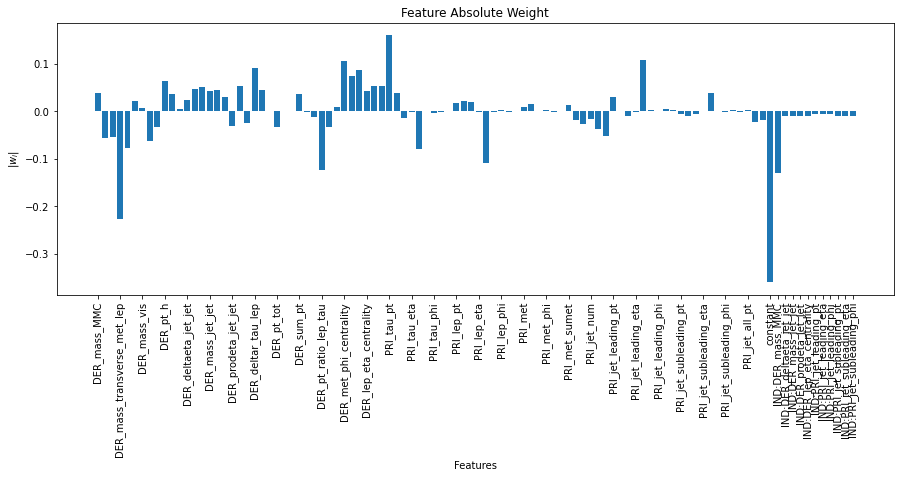

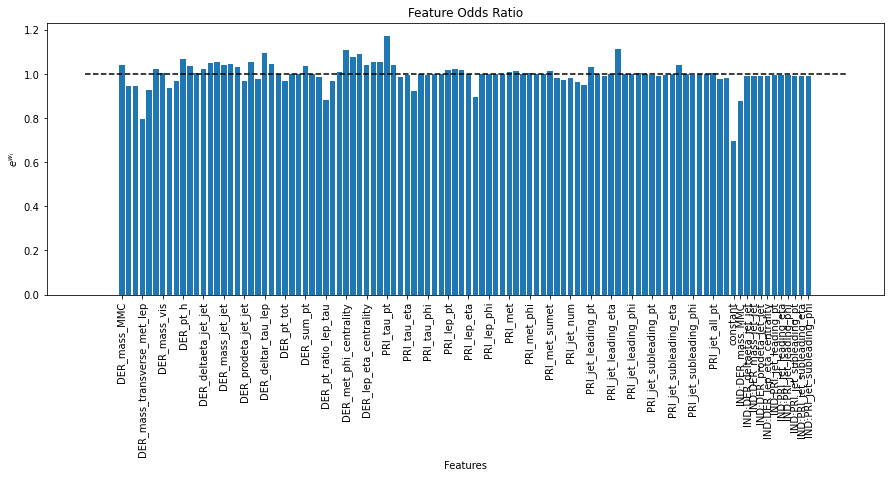

In [20]:
def feature_labels_full(df, nan_cols, degree):
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    nan_labels = [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
    
    poly_labels = []
    for name in col_names:
        for d in range(1,degree+1):
            poly_labels.append(f'{name}^{d}')
    
    labels = poly_labels + ['constant'] + nan_labels
    idx = np.arange(len(labels)) 
    
    return idx, labels

def feature_labels_sparse(df, nan_cols, degree):  
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    nan_labels = [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
    
    labels = col_names + ['constant'] + nan_labels
    
    idx = np.arange(len(labels)) 
    idx[:len(col_names)+1] *= degree
    idx[len(col_names)+1:] += idx[len(col_names)] - idx[len(col_names)+1] + 1
    
    return idx, labels

# Plot feature weights
fig = plt.figure(figsize=(15,5))
plt.bar(np.arange(w.shape[0]), w)

idx, labels = feature_labels_sparse(train, nan_cols, degree)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Features')
plt.ylabel('$|w_i|$')
plt.title('Feature Absolute Weight');

# Plot feature odds ratio
#  See: https://christophm.github.io/interpretable-ml-book/logistic.html#logistic
fig = plt.figure(figsize=(15,5))
plt.bar(np.arange(w.shape[0]), np.exp(w))
left, right = plt.xlim()
plt.hlines(1.0, left, right, linestyle='--')

idx, labels = feature_labels_sparse(train, nan_cols, degree)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Features')
plt.ylabel('$e^{w_i}$')
plt.title('Feature Odds Ratio');

In [21]:
idx, labels = feature_labels_full(train, nan_cols, degree)
odds_ratio = np.exp(w)
perm = np.argsort(-abs(1-odds_ratio))
for i in range(w.shape[0]):
    print(f'{labels[perm[i]]:30s} = {odds_ratio[perm[i]]-1:7.4f}')

constant                       = -0.3022
DER_mass_transverse_met_lep^1  = -0.2021
PRI_tau_pt^1                   =  0.1743
IND:DER_mass_MMC               = -0.1211
DER_pt_ratio_lep_tau^1         = -0.1168
PRI_jet_leading_eta^2          =  0.1146
DER_met_phi_centrality^1       =  0.1116
PRI_lep_eta^2                  = -0.1032
DER_deltar_tau_lep^1           =  0.0953
DER_met_phi_centrality^3       =  0.0901
DER_met_phi_centrality^2       =  0.0769
PRI_tau_eta^2                  = -0.0760
DER_mass_transverse_met_lep^2  = -0.0742
DER_pt_h^1                     =  0.0669
DER_mass_vis^2                 = -0.0609
DER_lep_eta_centrality^3       =  0.0550
DER_lep_eta_centrality^2       =  0.0545
DER_prodeta_jet_jet^2          =  0.0543
DER_mass_MMC^2                 = -0.0537
DER_deltaeta_jet_jet^3         =  0.0536
DER_mass_MMC^3                 = -0.0521
PRI_jet_num^3                  = -0.0502
DER_deltaeta_jet_jet^2         =  0.0492
DER_mass_jet_jet^2             =  0.0464
DER_deltar_tau_l

## Generate submission



In [ ]:
from helpers import create_csv_submission
import importlib

ids = test['Id']
y_pred = np.rint(sigmoid(tx_te @ w))
y_pred[y_pred == 0] = -1
y_pred[y_pred == 1] = 1

create_csv_submission(ids, y_pred, '../submission.csv')

## Notes



## It seems that adding the missing value indicators makes the method more "consitent with expectation". That is, the test loss and accuracy now follow similar patterns (both go up/down together). Without them, the highest accuracy tended to be where the test loss "blew up" (inf or nan).

